In [ ]:
import numpy as np
from scipy.optimize import curve_fit

from matplotlib import pyplot as plt
plt.style.use('dark_background')
from pypalettes import load_cmap
import warnings
warnings.filterwarnings("ignore") 

import plotly.io as pio
pio.renderers.default = 'notebook'


cmap = plt.get_cmap('Pastel1')
plt.get_cmap('Pastel1')
palette = load_cmap('Alexandrite')

In [1]:
import ReadCube as readcube
cube = readcube.Cube("LaTeP_OpenGGCM", step=0.05)
Q_GSE = cube.Q_GSE()

(subsec:shue-fit)=
# Shue model fitted to slices

We can extract some information about the shape and position of the simulation's magnetopause by analyzing the emissivity cubes themselves. It is expected that the absence of the solar wind inside the magnetosphere will result to zero - or almost zero- emissivity of X-rays in this region. Since the magnetopause is by definition the barrier that separates the magnetosphere from the solar wind, we can take the (almost) zero contour of a slice as the definition of the magnetosphere limit, meaning the magnetopause. We should keep in mind, however, that in reality the magnetopause is not an infinitely thin surface and further metrics could be used to define it. We will utilize such metrics in our next attempts to extract the surface as well.

We analyze two key slices of the emissivity cubes, the $z=0$ and $y=0$ slice, and extract the zero contour from their 2D contour maps:


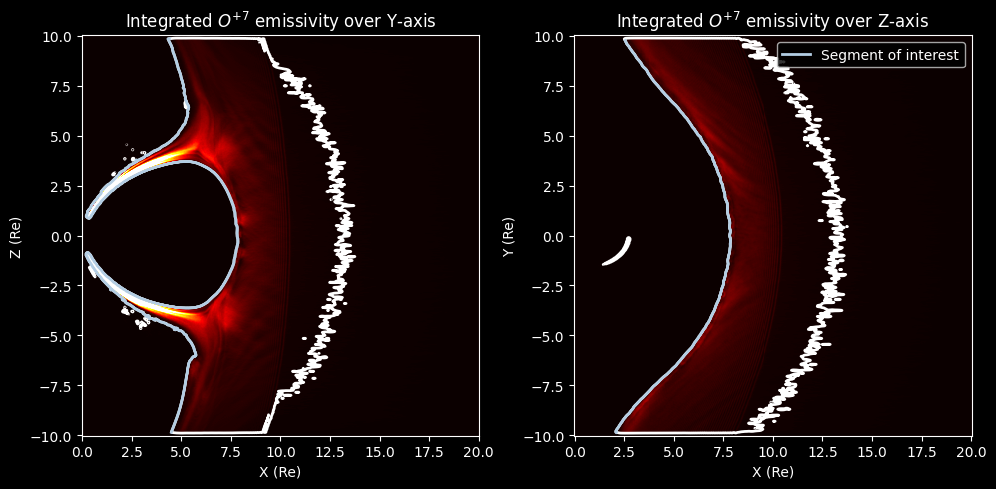

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].pcolormesh(cube.x_GSE, cube.z_GSE,Q_GSE[:,200,:].T, cmap='hot',vmax =1e-4)
cs = axs[0].contour(cube.x_GSE,cube.z_GSE,Q_GSE[:,200,:].T, levels=[1E-6], colors= 'white', linewidths=2)
contour = cs.allsegs[0]
x_zerocontour_xz = contour[0][:,0][2150:]
z_zerocontour_xz = contour[0][:,1][2150:]
axs[0].plot(x_zerocontour_xz,z_zerocontour_xz,linewidth=2, color=cmap(1),label = 'Segment of interest')
axs[0].set_title("Integrated $O^{+7}$ emissivity over Y-axis")
axs[0].set_xlabel("X (Re)")
axs[0].set_ylabel("Z (Re)")

axs[1].pcolormesh(cube.x_GSE, cube.y_GSE,Q_GSE[:,:,200].T, cmap='hot',vmax =1e-4)
cs = axs[1].contour(cube.x_GSE,cube.y_GSE,Q_GSE[:,:,200].T, levels=[1E-6], colors= 'white', linewidths=2)
contour = cs.allsegs[0]
x_zerocontour_xy = contour[0][:,0][2480:]
y_zerocontour_xy = contour[0][:,1][2480:]
axs[1].plot(x_zerocontour_xy,y_zerocontour_xy,linewidth=2, color=cmap(1),label = 'Segment of interest')
axs[1].set_title("Integrated $O^{+7}$ emissivity over Z-axis")
axs[1].set_xlabel("X (Re)")
axs[1].set_ylabel("Y (Re)")

plt.legend()
plt.tight_layout()
plt.show()

Empirical models are typically expressed in spherical coordinates as defined in {ref}`coordinate`, where z slice corresponds to $\phi=0^o$ and the y slice to $\phi=90^o$. In order to fit the Shue model to the zero contours we transform them this spherical system, and use the `curve_fit` function of `SciPy` to estimate $r_0$ and $\alpha$.

The Shue model is the most simplistic description of the magnetopause, accounting for no asymmetries or indentations, and having full rotational symmetry over the GSE x-axis. Therefore, its full spherical expression will remain unchanged:

$$
    r(\theta,\phi) = r_0 \left( \frac{2}{1 + \cos \theta} \right)^\alpha
$$

where $r_0$ is the subsolar distance and $a$ a shape parameter that determines the flaring. 

We can approximate the $\phi=0$ slice of the magnetopause by best fitting these parameters to the zero emissivity contour slice. The asymmetries and indentation introduced by the cusps in the y slice, cannot be described by this model. Nonetheless, we will use this fitted model as first approximation of the 3D surface of the simulated magnetopause. 

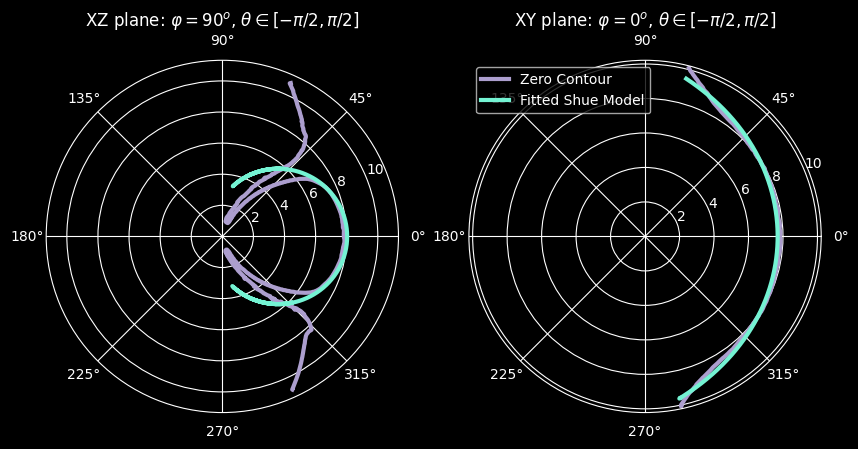

Estimated values from equatorial plane: 
 Subsolar distance: r0 = 7.690695963489819 RE 
 Flaring: a = 0.4412905155362411


In [4]:
def shue(theta, r0, alpha ):
    return r0 * (2 / (1 + np.cos(theta)))**alpha

fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': 'polar'})

# XZ plane
r_xz, theta_xz = cube.cart2pol(x_zerocontour_xz,z_zerocontour_xz)
popt, pcov = curve_fit(shue, theta_xz, r_xz, p0=[8,0.5])  # Initial guess: r0=8, alpha=0.5
r0_xz, alpha_xz = popt  # Best-fit parameters
axs[0].plot(theta_xz,r_xz, label='Zero contour',linewidth=3, color=palette(6))
axs[0].set_title("XZ plane: $φ = 90^o$, $θ \in [-π/2,π/2]$")
axs[0].plot(theta_xz,shue(theta_xz,r0_xz,alpha_xz),linewidth=3, color=palette(3),label='Fitted Shue Model')

# XY plane
r_xy, theta_xy = cube.cart2pol(x_zerocontour_xy,y_zerocontour_xy)
popt, pcov = curve_fit(shue, theta_xy, r_xy, p0=[8,0.5])  # Initial guess: r0=8, alpha=0.5
r0_xy, alpha_xy = popt  # Best-fit parameters
axs[1].plot(theta_xy,r_xy, label='Zero Contour',linewidth=3, color= palette(6))
axs[1].set_title("XY plane: $φ= 0^o$, $θ \in [-π/2,π/2]$")
axs[1].plot(theta_xy,shue(theta_xy,r0_xy,alpha_xy),linewidth=3, color=palette(3), label='Fitted Shue Model')

plt.legend()
plt.show()

print(f"Estimated values from equatorial plane: \n Subsolar distance: r0 = {r0_xy} RE \n Flaring: a = {alpha_xy}")

The equatorial plane is giving a good estimation of where the magnetopause is, while the XZ plane cannot be described by such a simplistic model. The flaring parameter is trying to capture the cusps instead of the outer boundary. 

Building the full surface just by using the contour points is challenging due to the unpredictable nature of the contour output of `matplot`. We can always choose the longest contour, but we still have keep only the section of interest in an arbitrary manner.